In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import boxcox1p
import pickle
from os import path
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

# data Visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.express as px 
from plotnine import ggplot, aes, geom_line, geom_point, facet_wrap, theme
import plotly.graph_objects as go
# Machine learning algorithms and model evaluation
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from lightgbm import LGBMRegressor
# Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler



1. Data Preprocessing:
Load the datasets


In [2]:
# Load the three datasets
average_hours = pd.read_csv('Resources/average-usual-weekly-hours-worked-women-15-years-and-older.csv')
employment_ratio = pd.read_csv("Resources/female-employment-to-population-ratio.csv")
wage_gap = pd.read_csv("Resources/gender-wage-gap-oecd.csv")
percapita_labor = pd.read_csv("Resources/female-labor-force-participation-rates-by-national-per-capita-income.csv")
school_years = pd.read_csv("Resources/mean-years-of-schooling-female.csv")
maternity_leave = pd.read_csv("Resources/paid-leave-at-least-14-weeks-mothers.csv")
labor_sector = pd.read_csv("Resources/share-of-female-workers-by-sector.csv")


In [3]:
# Columns and Rows for each of the dataset 
print(f'Shape of average_hours DataFrame: {average_hours.shape}')
print(f'Shape of employment_ratio DataFrame: {employment_ratio.shape}')
print(f'Shape of wage_gap DataFrame: {wage_gap.shape}')
print(f'Shape of percapita_labor DataFrame: {percapita_labor.shape}')
print(f'Shape of school_years DataFrame: {school_years.shape}')
print(f'Shape of maternity_leave DataFrame: {maternity_leave.shape}')
print(f'Shape of labor_sector DataFrame: {labor_sector.shape}')

Shape of average_hours DataFrame: (971, 4)
Shape of employment_ratio DataFrame: (3919, 4)
Shape of wage_gap DataFrame: (636, 4)
Shape of percapita_labor DataFrame: (7185, 6)
Shape of school_years DataFrame: (1502, 4)
Shape of maternity_leave DataFrame: (10206, 4)
Shape of labor_sector DataFrame: (2781, 6)


In [4]:
# Rename Columns to make it shorter
average_hours = average_hours.rename(columns={'Average weekly hours worked (women, 15+) (OECD Labor Force Statistics (2017))': 'Avg_Hours_Worked'})
employment_ratio = employment_ratio.rename(columns={'Employment to population ratio, 15+, female (%) (national estimate)': 'Emp_Pop_Ratio'})
wage_gap = wage_gap.rename(columns={'Gender wage gap (OECD 2017)': 'Gender_Wage_Gap'})
percapita_labor = percapita_labor.rename(columns={'Labor force participation rate, female (% of female population ages 15+) (modeled ILO estimate)': 'Labor_Force'})
school_years = school_years.rename(columns={'Mean years of schooling (ISCED 1 or higher), population 25+ years, female': 'School_Years_Mean'})
maternity_leave = maternity_leave.rename(columns={'Paid leave of at least 14 weeks available to mothers (1=yes; 0=no)': 'Paid_Leave'})
labor_sector = labor_sector.rename(columns={'Female share of employment in agriculture (%)': 'Argiculture','Female share of employment in industry (%)': 'Industry','Female share of employment in services (%)': 'Services'})


In [5]:
average_hours.dropna(inplace=True)
employment_ratio.dropna(inplace=True)


In [6]:
average_hours

,Entity,Code,Year,Avg_Hours_Worked
0,Australia,AUS,2001,31.062685
1,Australia,AUS,2002,30.964121
2,Australia,AUS,2003,30.929489
3,Australia,AUS,2004,31.107463
4,Australia,AUS,2005,31.109187
...,...,...,...,...
966,United Kingdom,GBR,2012,31.234553
967,United Kingdom,GBR,2013,31.453945
968,United Kingdom,GBR,2014,31.682259
969,United Kingdom,GBR,2015,31.807419


In [7]:
# Merge the datasets
merged_df= average_hours.merge(employment_ratio, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(wage_gap, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(percapita_labor, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(school_years, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(maternity_leave, on=['Entity', 'Code', 'Year'], how='outer')
merged_df= merged_df .merge(labor_sector, on=['Entity', 'Code', 'Year'], how='outer')

# Check the result
print(merged_df.shape)


(11400, 14)


In [8]:
print(merged_df.isnull().sum())

Entity                                                     0
Code                                                     458
Year                                                       0
Avg_Hours_Worked                                       10512
Emp_Pop_Ratio                                           7716
Gender_Wage_Gap                                        10764
Labor_Force                                             4969
GDP per capita, PPP (constant 2017 international $)     4838
Continent                                              11115
School_Years_Mean                                       9898
Paid_Leave                                              1194
Argiculture                                             8675
Industry                                                8653
Services                                                8655
dtype: int64


In [9]:
#Drop colum "Continent"
merged_df = merged_df.drop("Continent", axis=1)

In [10]:
# Check for duplicates
duplicates = merged_df.duplicated().sum()
print(f"Number of duplicates: {duplicates}")

Number of duplicates: 0


In [11]:
filtered_df = merged_df[merged_df['Code'].str.len()<=3]


In [12]:
filtered_df 

,Entity,Code,Year,Avg_Hours_Worked,Emp_Pop_Ratio,Gender_Wage_Gap,Labor_Force,"GDP per capita, PPP (constant 2017 international $)",School_Years_Mean,Paid_Leave,Argiculture,Industry,Services
1,Afghanistan,AFG,1970,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,Afghanistan,AFG,1971,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,Afghanistan,AFG,1972,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,Afghanistan,AFG,1973,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
5,Afghanistan,AFG,1974,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11395,Zimbabwe,ZWE,2019,NaN,56.447,NaN,60.730,2203.3967,8.07002,1.0,NaN,NaN,NaN
11396,Zimbabwe,ZWE,2020,NaN,NaN,NaN,59.848,1990.3195,NaN,1.0,NaN,NaN,NaN
11397,Zimbabwe,ZWE,2021,NaN,54.094,NaN,60.147,2115.1445,NaN,1.0,NaN,NaN,NaN
11398,Zimbabwe,ZWE,2022,NaN,NaN,NaN,60.072,2207.9570,NaN,1.0,NaN,NaN,NaN


In [13]:
# Check the data types of each column
print(filtered_df.dtypes)


Entity                                                  object
Code                                                    object
Year                                                     int64
Avg_Hours_Worked                                       float64
Emp_Pop_Ratio                                          float64
Gender_Wage_Gap                                        float64
Labor_Force                                            float64
GDP per capita, PPP (constant 2017 international $)    float64
School_Years_Mean                                      float64
Paid_Leave                                             float64
Argiculture                                            float64
Industry                                               float64
Services                                               float64
dtype: object


In [14]:
# Perform some basic EDA
print(filtered_df.describe())


               Year  Avg_Hours_Worked  Emp_Pop_Ratio  Gender_Wage_Gap  \
count  10778.000000        888.000000    3662.000000       636.000000   
mean    1997.015866         35.485752      44.861098        19.385535   
std       15.581715          4.047832      14.312533        10.053530   
min     1960.000000         24.038079       2.500000         0.000000   
25%     1984.000000         32.523503      36.909500        13.200000   
50%     1997.000000         35.616393      46.108000        17.900000   
75%     2011.000000         38.548941      53.131750        23.400000   
max     2023.000000         44.813507      94.500000        52.800000   

       Labor_Force  GDP per capita, PPP (constant 2017 international $)  \
count  5951.000000                                        6085.000000     
mean     49.674714                                       18408.744201     
std      15.605830                                       20667.723060     
min       4.948000                        

In [15]:
# Check for null values
print(filtered_df.isnull().sum())

Entity                                                     0
Code                                                       0
Year                                                       0
Avg_Hours_Worked                                        9890
Emp_Pop_Ratio                                           7116
Gender_Wage_Gap                                        10142
Labor_Force                                             4827
GDP per capita, PPP (constant 2017 international $)     4693
School_Years_Mean                                       9277
Paid_Leave                                               626
Argiculture                                             8088
Industry                                                8075
Services                                                8077
dtype: int64


In [16]:
# Define numerical and catrgorical columns 
numerical_cols = ['Year', 'Avg_Hours_Worked', 'Emp_Pop_Ratio', 'Gender_Wage_Gap', 
                  'Labor_Force', 'GDP per capita, PPP (constant 2017 international $)', 
                  'School_Years_Mean', 'Paid_Leave', 'Argiculture', 'Industry', 
                  'Services']

categorical_cols = ['Entity', 'Code']

In [17]:
len(filtered_df)

10778

In [18]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

# Impute null values in numerical columns using KNNImputer
imputer_num = KNNImputer(n_neighbors=5)
imputed_num_data = imputer_num.fit_transform(filtered_df[numerical_cols])

# One-Hot Encode categorical columns
#ohe = OneHotEncoder(handle_unknown='ignore')
#encoded_array = ohe.fit_transform(filtered_df[categorical_cols])
#encoded_df = pd.DataFrame(encoded_array.toarray(), columns=ohe.get_feature_names_out(categorical_cols))

# Concatenate imputed numerical columns with one-hot encoded categorical columns
#df_encoded = pd.concat([pd.DataFrame(imputed_num_data, columns=numerical_cols), encoded_df], axis=1)


In [19]:
len(imputed_num_data)

10778

In [20]:
filtered_df

,Entity,Code,Year,Avg_Hours_Worked,Emp_Pop_Ratio,Gender_Wage_Gap,Labor_Force,"GDP per capita, PPP (constant 2017 international $)",School_Years_Mean,Paid_Leave,Argiculture,Industry,Services
1,Afghanistan,AFG,1970,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,Afghanistan,AFG,1971,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,Afghanistan,AFG,1972,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,Afghanistan,AFG,1973,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
5,Afghanistan,AFG,1974,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11395,Zimbabwe,ZWE,2019,NaN,56.447,NaN,60.730,2203.3967,8.07002,1.0,NaN,NaN,NaN
11396,Zimbabwe,ZWE,2020,NaN,NaN,NaN,59.848,1990.3195,NaN,1.0,NaN,NaN,NaN
11397,Zimbabwe,ZWE,2021,NaN,54.094,NaN,60.147,2115.1445,NaN,1.0,NaN,NaN,NaN
11398,Zimbabwe,ZWE,2022,NaN,NaN,NaN,60.072,2207.9570,NaN,1.0,NaN,NaN,NaN


In [21]:
# Check for null values before imputation
print("Null values before imputation:")
print(filtered_df[numerical_cols].isnull().sum())

#imputed_num_data = imputer_num.fit_transform(filtered_df[numerical_cols])

# Check imputed data for null values
imputed_num_df = pd.DataFrame(imputed_num_data, columns=numerical_cols)
imputed_num_df.reset_index(inplace=True, drop=True)
cat_df= filtered_df[categorical_cols]
cat_df.reset_index(inplace=True, drop=True)

print(cat_df.isnull().sum())
print("Null values after imputation:")
print(imputed_num_df.isnull().sum())

Null values before imputation:
Year                                                       0
Avg_Hours_Worked                                        9890
Emp_Pop_Ratio                                           7116
Gender_Wage_Gap                                        10142
Labor_Force                                             4827
GDP per capita, PPP (constant 2017 international $)     4693
School_Years_Mean                                       9277
Paid_Leave                                               626
Argiculture                                             8088
Industry                                                8075
Services                                                8077
dtype: int64
Entity    0
Code      0
dtype: int64
Null values after imputation:
Year                                                   0
Avg_Hours_Worked                                       0
Emp_Pop_Ratio                                          0
Gender_Wage_Gap                                

In [22]:
# concatenate the imputed numerical columns with the original categorical columns
# pd.DataFrame(imputed_num_data, columns=numerical_cols)
imputed_df = pd.concat([imputed_num_df, cat_df], axis=1)
#imputed_df[categorical_cols] = imputed_df[categorical_cols].astype('category')



In [23]:
imputed_df

,Year,Avg_Hours_Worked,Emp_Pop_Ratio,Gender_Wage_Gap,Labor_Force,"GDP per capita, PPP (constant 2017 international $)",School_Years_Mean,Paid_Leave,Argiculture,Industry,Services,Entity,Code
0,1970.0,34.954374,39.1824,44.66,73.5150,6244.07698,4.418104,0.0,22.872,21.256,34.526,Afghanistan,AFG
1,1971.0,34.954374,38.7800,44.66,64.5014,6244.07698,2.735286,0.0,36.676,31.782,39.346,Afghanistan,AFG
2,1972.0,34.954374,45.2008,44.66,65.7420,6244.07698,3.322344,0.0,30.514,31.310,43.682,Afghanistan,AFG
3,1973.0,34.954374,35.7494,42.74,65.7420,6244.07698,1.540688,0.0,30.746,22.934,39.590,Afghanistan,AFG
4,1974.0,34.954374,35.3352,40.68,67.1980,6244.07698,3.103306,0.0,21.506,17.000,35.786,Afghanistan,AFG
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10773,2019.0,31.863286,56.4470,22.62,60.7300,2203.39670,8.070020,1.0,28.060,17.386,52.444,Zimbabwe,ZWE
10774,2020.0,34.076591,53.1956,22.80,59.8480,1990.31950,11.204198,1.0,26.126,18.104,52.760,Zimbabwe,ZWE
10775,2021.0,31.863286,54.0940,29.26,60.1470,2115.14450,9.139034,1.0,30.412,21.302,51.732,Zimbabwe,ZWE
10776,2022.0,34.616941,52.9190,22.80,60.0720,2207.95700,10.599860,1.0,29.412,15.562,52.760,Zimbabwe,ZWE


In [24]:
print(imputed_df.isnull().sum())

Year                                                   0
Avg_Hours_Worked                                       0
Emp_Pop_Ratio                                          0
Gender_Wage_Gap                                        0
Labor_Force                                            0
GDP per capita, PPP (constant 2017 international $)    0
School_Years_Mean                                      0
Paid_Leave                                             0
Argiculture                                            0
Industry                                               0
Services                                               0
Entity                                                 0
Code                                                   0
dtype: int64


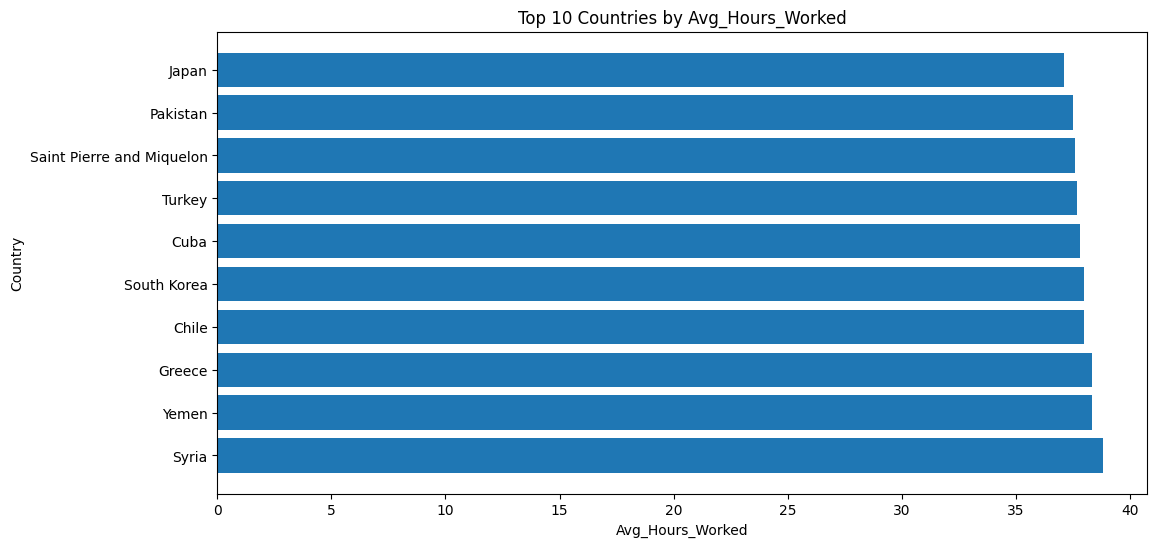

In [25]:
# Get the top 10 countries by Average Hours Worked  
top_countries = imputed_df.groupby('Entity')['Avg_Hours_Worked'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Avg_Hours_Worked')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Avg_Hours_Worked'])
plt.title("Top 10 Countries by Avg_Hours_Worked")
plt.xlabel("Avg_Hours_Worked")
plt.ylabel("Country")
plt.show()

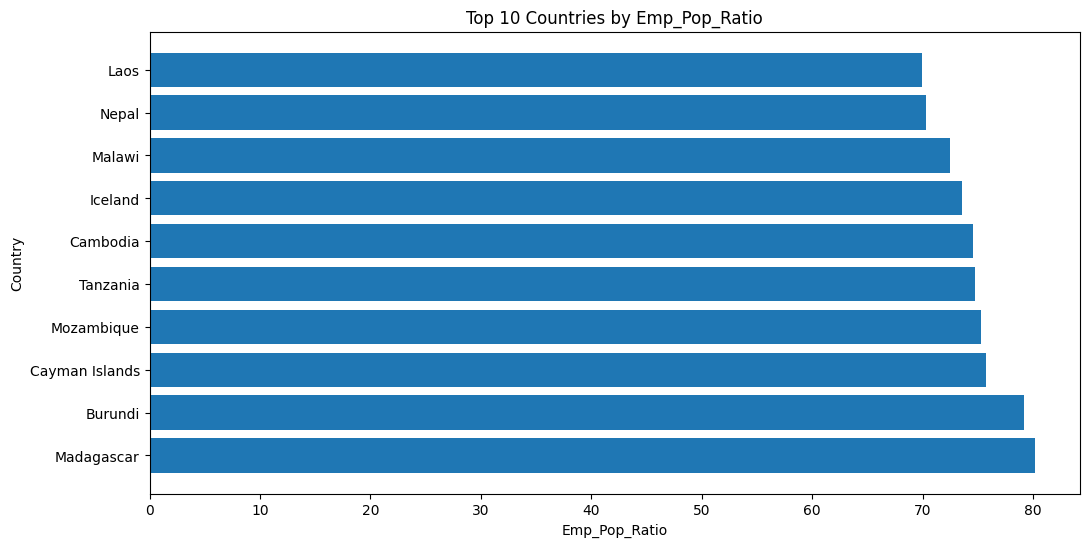

In [26]:
# Get the top 10 countries by Emp_Pop_Ratio  
top_countries = merged_df.groupby('Entity')['Emp_Pop_Ratio'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Emp_Pop_Ratio')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Emp_Pop_Ratio'])
plt.title("Top 10 Countries by Emp_Pop_Ratio")
plt.xlabel("Emp_Pop_Ratio")
plt.ylabel("Country")
plt.show()

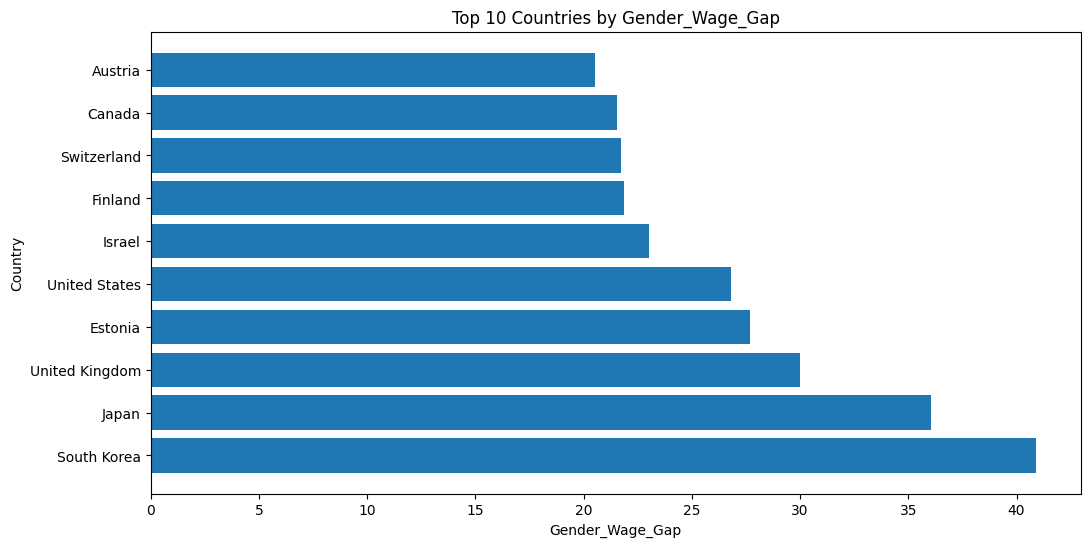

In [27]:
# Get the top 10 countries by Gender_Wage_Gap
top_countries = merged_df.groupby('Entity')['Gender_Wage_Gap'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Gender_Wage_Gap')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Gender_Wage_Gap'])
plt.title("Top 10 Countries by Gender_Wage_Gap")
plt.xlabel("Gender_Wage_Gap")
plt.ylabel("Country")
plt.show()

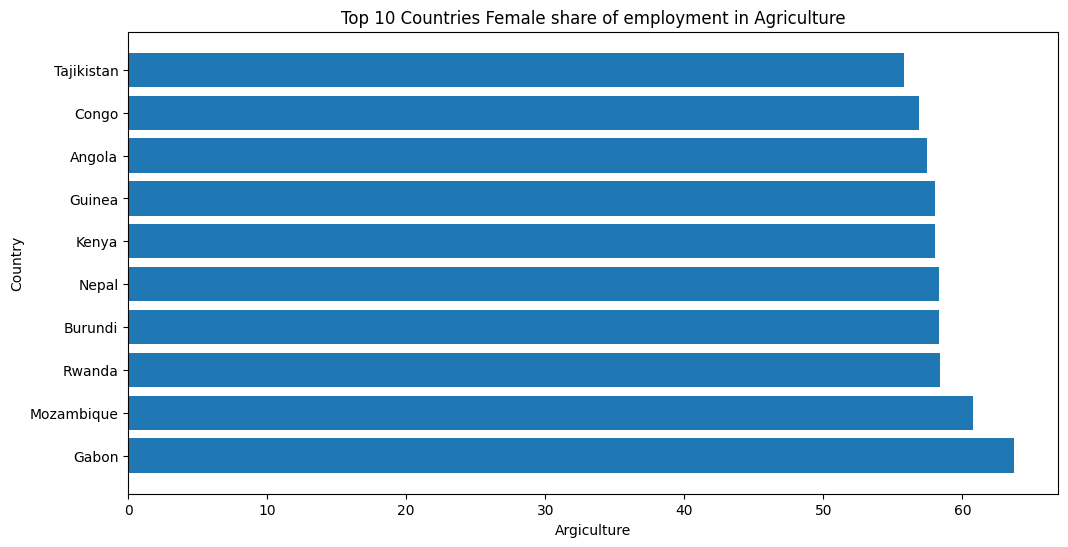

In [28]:
# Get the top 10 countries by Argiculture
top_countries = merged_df.groupby('Entity')['Argiculture'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Argiculture')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Argiculture'])
plt.title("Top 10 Countries Female share of employment in Agriculture")
plt.xlabel("Argiculture")
plt.ylabel("Country")
plt.show()

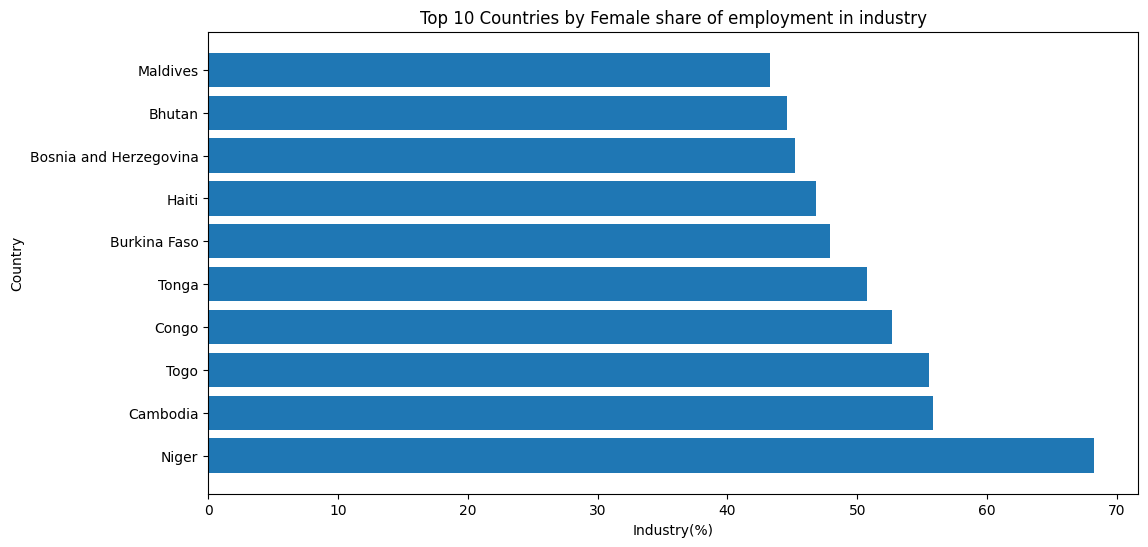

In [29]:
# Get the top 10 countries by Industry
top_countries = merged_df.groupby('Entity')['Industry'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Industry')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Industry'])
plt.title("Top 10 Countries by Female share of employment in industry")
plt.xlabel("Industry(%)")
plt.ylabel("Country")
plt.show()

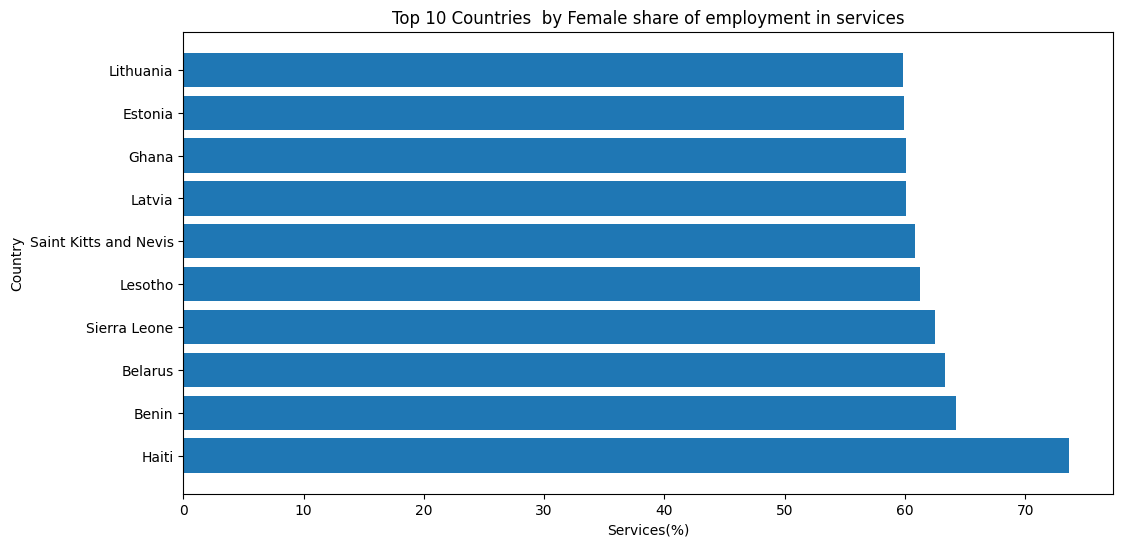

In [30]:
# Get the top 10 countries by Services
top_countries = merged_df.groupby('Entity')['Services'].mean().reset_index()
top_countries = top_countries.nlargest(10, 'Services')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(top_countries['Entity'], top_countries['Services'])
plt.title("Top 10 Countries  by Female share of employment in services")
plt.xlabel("Services(%)")
plt.ylabel("Country")
plt.show()

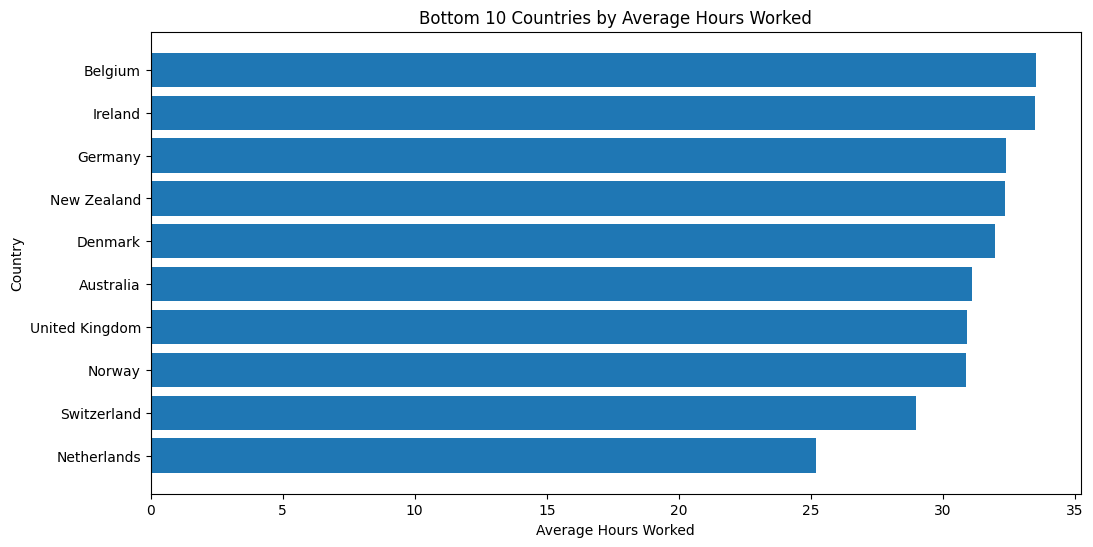

In [31]:

# Get the bottom 10 countries by average hours worked
bottom_countries = merged_df.groupby('Entity')['Avg_Hours_Worked'].mean().reset_index()
bottom_countries = bottom_countries.nsmallest(10, 'Avg_Hours_Worked')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(bottom_countries['Entity'], bottom_countries['Avg_Hours_Worked'])
plt.title("Bottom 10 Countries by Average Hours Worked")
plt.xlabel("Average Hours Worked")
plt.ylabel("Country")
plt.show()

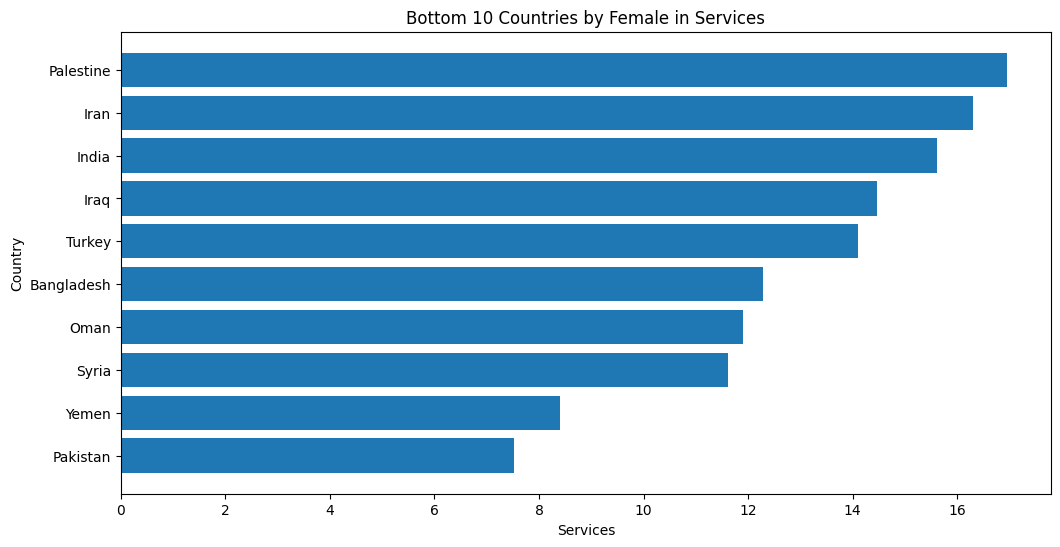

In [32]:
# Get the top 10 countries by Services
bottom_countries = merged_df.groupby('Entity')['Services'].mean().reset_index()
bottom_countries = bottom_countries.nsmallest(10, 'Services')

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(bottom_countries['Entity'], bottom_countries['Services'])
plt.title("Bottom 10 Countries by Female in Services")
plt.xlabel("Services")
plt.ylabel("Country")
plt.show()